#### <strong>Load and prepare data: 注意讀入的資料轉換為 Tensor 型態的過程</strong>

In [10]:
from scipy.io import loadmat
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data from .mat file
mnist = loadmat("/Users/andrewhsu/Library/Mobile Documents/com~apple~CloudDocs/VsCode_python/mat/mnist-original.mat")
X = mnist["data"].T.astype('float32')  # 轉置數據以符合原始格式，並轉換類型為浮點數
y = mnist["label"][0].astype('int64')  # 類型轉換為整數

# Normalize the data (standardization)
X /= 255.0  # 將像素值縮放到 [0, 1] 範圍

# Reshape X to match the shape used in the previous code
X = X.reshape(-1, 1, 28, 28)  # 將數據轉換為 N x 1 x 28 x 28，其中 N 是樣本數

# set random seed for reproducibility
seed = 18
np.random.seed(seed)

# Split data into training and testing sets
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

# Check shapes of data
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Define batch size
batch_size = 128

# Create DataLoader for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


X_train.shape: torch.Size([56000, 1, 28, 28])
y_train.shape: torch.Size([56000])
X_test.shape: torch.Size([14000, 1, 28, 28])
y_test.shape: torch.Size([14000])


#### <strong>Define the network</strong>

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
 
class Net(nn.Module):
 
    def __init__(self):
        super(Net, self).__init__()
         
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 input channel, 6 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channel, 16 output channels, 5x5 square convolution
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 4*4 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 output classes
 
    def forward(self, x):
         
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
 
 
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
 
net = Net().to(device)
print(net)

Using cpu device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### <strong>use torch summary to see the details</strong>

In [13]:
from torchsummary import summary

summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 16, 8, 8]           2,416
            Linear-3                  [-1, 120]          30,840
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


#### <strong>觀察將進入訓練的影像資料，並試做 network 是否設計有誤</strong>

(1, 10)
tensor([[ 0.0401,  0.0783, -0.0113, -0.0298, -0.1154,  0.0571,  0.0663,  0.1172,
         -0.0920,  0.0006]])
tensor([[7]])
[[ 0.0400592   0.07828365 -0.01126115 -0.02979235 -0.11539388  0.05711265
   0.06632292  0.1172273  -0.09196381  0.00056595]]
torch.Size([128, 1, 28, 28])


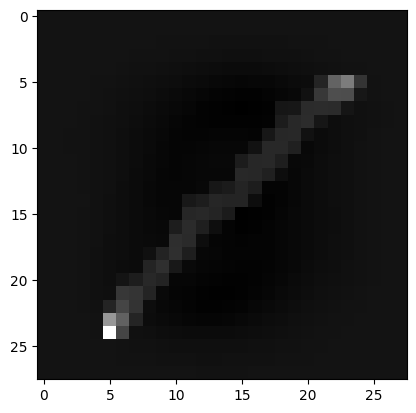

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


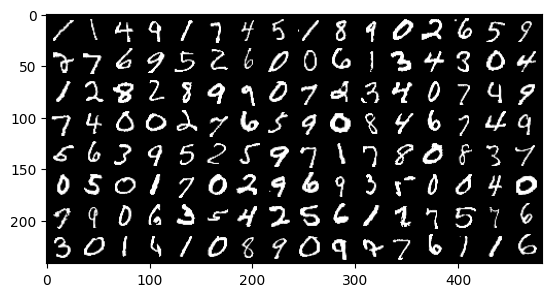

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
 
input = train_dataset[0][0].reshape(1, 1, 28, 28)
# 觀察 network 輸出結果
out = net(input.to(device))
print(out.to("cpu").detach().numpy().shape)
print(out.data)
print(out.data.max(1, keepdim=True)[1])
print(out.to("cpu").detach().numpy())
 
# get some random training images
dataiter = iter(train_loader) # an iterable object
images, labels = next(dataiter) # get the next batch
print(images.shape)
 
# show a single image
a_image = images[0]
a_image_ = np.transpose(a_image, (1, 2, 0))
plt.imshow(a_image_, cmap='gray')
plt.show()
 
# show a grid of images
montage = torchvision.utils.make_grid(images, nrow=16) # make a grid of images with 16 images per row
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray')
plt.show()

#### <strong>Define a Loss function and optimizer:</strong>

use a Classification Cross-Entropy loss and SGD with momentum

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net2.parameters(), lr = 0.01) 

#### <strong>Train the network</strong>

In [18]:
epochs = 15
for epoch in range(epochs):  # loop over the dataset multiple times
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) # move to GPU if available
     
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs) # forward pass
        loss = criterion(outputs, labels) # compute loss
        # writer.add_scalar("Loss/train", loss, epoch)
        loss.backward() # compute gradients
        optimizer.step() # update weights
 
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[epoch : {epoch + 1}, batch: {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
 
print('Finished Training')

[epoch : 1, batch:   200] loss: 2.289
[epoch : 1, batch:   400] loss: 2.215
[epoch : 2, batch:   200] loss: 1.192
[epoch : 2, batch:   400] loss: 0.471
[epoch : 3, batch:   200] loss: 0.323
[epoch : 3, batch:   400] loss: 0.280
[epoch : 4, batch:   200] loss: 0.229
[epoch : 4, batch:   400] loss: 0.211
[epoch : 5, batch:   200] loss: 0.178
[epoch : 5, batch:   400] loss: 0.166
[epoch : 6, batch:   200] loss: 0.145
[epoch : 6, batch:   400] loss: 0.136
[epoch : 7, batch:   200] loss: 0.123
[epoch : 7, batch:   400] loss: 0.119
[epoch : 8, batch:   200] loss: 0.107
[epoch : 8, batch:   400] loss: 0.104
[epoch : 9, batch:   200] loss: 0.101
[epoch : 9, batch:   400] loss: 0.089
[epoch : 10, batch:   200] loss: 0.090
[epoch : 10, batch:   400] loss: 0.085
[epoch : 11, batch:   200] loss: 0.081
[epoch : 11, batch:   400] loss: 0.080
[epoch : 12, batch:   200] loss: 0.072
[epoch : 12, batch:   400] loss: 0.079
[epoch : 13, batch:   200] loss: 0.072
[epoch : 13, batch:   400] loss: 0.069
[epo

#### <strong>save the trained model for later use:</strong>
做為再次訓練的起點或訓練完成後的使用狀態

In [19]:
PATH = '/Users/andrewhsu/Library/Mobile Documents/com~apple~CloudDocs/VsCode_python/SHALLOW_ML/digit10_net.pt' # .pth will collide with the PyTorch JIT
torch.save(net.state_dict(), PATH)

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the {len(test_dataset)} test images: {100 * correct // total} %')


Accuracy of the network on the 14000 test images: 97 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


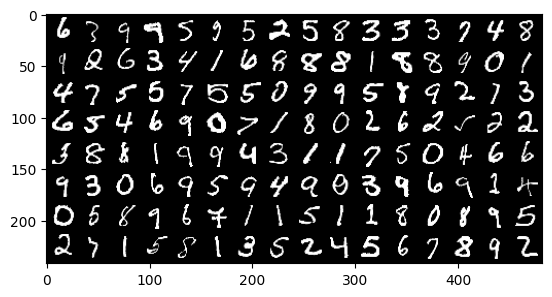

The predictions:
 {tensor([[6, 7, 9, 9, 5, 9, 5, 2, 5, 8, 3, 3, 3, 7, 4, 8],
        [9, 2, 6, 3, 4, 1, 6, 8, 8, 8, 1, 8, 8, 9, 0, 1],
        [4, 7, 5, 5, 7, 5, 5, 0, 9, 9, 5, 8, 9, 2, 7, 3],
        [6, 5, 4, 6, 9, 0, 7, 1, 8, 0, 2, 6, 2, 5, 2, 2],
        [3, 8, 8, 1, 9, 9, 4, 3, 1, 1, 7, 5, 0, 4, 6, 6],
        [9, 3, 0, 6, 9, 5, 9, 4, 9, 0, 3, 9, 6, 9, 1, 4],
        [0, 5, 8, 9, 6, 7, 1, 1, 5, 1, 1, 8, 0, 8, 9, 5],
        [2, 7, 1, 5, 8, 1, 3, 5, 2, 4, 5, 6, 7, 8, 9, 2]])}
Accuracy of the network on the 64 test images: 99.21875 %


In [22]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
 
sample_idx = torch.randint(len(test_loader), size=(1,)).item()
dataiter = iter(test_loader)
for i in range(sample_idx): # randomly select a batch
    images, labels = next(dataiter)
 
# print test images
nrow = 16 # number of images per row
montage = torchvision.utils.make_grid(images, nrow=nrow)
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray')
plt.show()
 
# predict the labels
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print("The predictions:\n", {predicted.reshape(batch_size // nrow, nrow)})
 
total = labels.size(0)
correct_rate = (predicted == labels.to(device)).sum().item() / total
print(f'Accuracy of the network on the 64 test images: {100 * correct_rate} %')